In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
import HomeMade as hm
import pandas as pd

In [18]:
# ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
ML1 = "v0_chi2 v0_px1 v0_py1 v0_py v0_py2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [3]:
N = 6e5

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
# train_split_data = len(data)//3
train_test_split_data = int(len(data)*0.5)
train_data = data[:train_test_split_data]
test_data = data[train_test_split_data:]

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_split_mc = int(len(data)*0.8)
train_mc = mc[:train_test_split_mc]
test_mc = mc[train_test_split_mc:]

In [47]:
def reweight_train(data,mc,feats,cla,eval_data=None,eval_mc=None,plot=True,reweighing=True,q_weights=0.9999):
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from hep_ml.reweight import GBReweighter
    from sklearn.metrics import roc_curve, roc_auc_score

    scaler_mc = MinMaxScaler()
    scaler_data = MinMaxScaler()

    def remove_outliers(data,q1=0.05,q2=0.95):
        mask = np.ones(len(data),dtype=bool)
        for col in data.columns:
            mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
        return mask
    
    #Try and remove outliers at first step
    data = data[remove_outliers(data[feats])]
    mc = mc[remove_outliers(mc[feats])]
    
    data_split = len(data)//2
    mc_split = len(mc)//2
    
    train_data = data[:data_split]
    train_data_cla = data[data_split:]
    
    train_mc = mc[:mc_split]
    train_mc_cla = mc[mc_split:]
    
#     scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats][remove_outliers(train_data[feats])]),columns=feats)
#     scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats][remove_outliers(train_mc[feats])]),columns=feats)
    scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats]),columns=feats)
    scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats]),columns=feats)

    scaled_train_data_cla = pd.DataFrame(scaler_data.transform(train_data_cla[feats]),columns=feats)
    scaled_train_mc_cla = pd.DataFrame(scaler_mc.transform(train_mc_cla[feats]),columns=feats)
    
#     #Try and remove outliers
#     scaled_train_data_cla[remove_outliers(scaled_train_data_cla)]
#     scaled_train_mc_cla[remove_outliers(scaled_train_mc_cla)]
    
    if plot:
        for feat in feats:
            scaled_train_data[feat].hist(bins=100,alpha=0.5);
            scaled_train_mc[feat].hist(bins=100,alpha=0.5);
            plt.yscale('log')
            plt.title(feat)
            plt.show()
    
    if reweighing:
        reweighter = GBReweighter(n_estimators=100,max_depth=4,min_samples_leaf=800,loss_regularization=10.0)
        sample = min(len(scaled_train_mc),len(scaled_train_data))
        reweighter.fit(original=scaled_train_mc.sample(sample), target=scaled_train_data.sample(sample))
        
        mc_weights = reweighter.predict_weights(scaled_train_mc_cla)
        
        mask = mc_weights < np.quantile(mc_weights, (q_weights))
        
        plt.hist(mc_weights[mask],bins=100)
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        
        if plot:
            print(len(scaled_train_data_cla),len(scaled_train_mc_cla[mask]))
            for feat in feats:
                scaled_train_data_cla[feat].hist(bins=100,alpha=0.5);
                scaled_train_mc_cla[mask][feat].hist(bins=100,alpha=0.5,weights=mc_weights[mask]);
                plt.yscale('log')
                plt.title(feat)
                plt.show()
        
        cla.fit(X=scaled_train_mc_cla[mask],
               y=train_mc_cla.trueKs[mask],
               sample_weight = mc_weights[mask])
        
        if type(eval_data) != type(None) and type(eval_mc) != type(None):
            scaled_eval_data = pd.DataFrame(scaler_data.transform(eval_data[feats]),columns=feats)
            scaled_eval_mc = pd.DataFrame(scaler_mc.transform(eval_mc[feats]),columns=feats)
            
            #Check how distinguishable after reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))),
                        sample_weight = np.append(mc_weights[mask],np.ones(len(scaled_train_data_cla))))
            print(eval_cla.feature_importances_)
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fig, ax = plt.subplots()
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'b.')
            
            #check before reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))))
            print(eval_cla.feature_importances_)
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'rx')
    else:
        cla.fit(X=scaled_train_mc_cla,
                y=train_mc_cla.trueKs)
    return scaler_data, scaler_mc

In [5]:
cla_reweight1 = xgb.XGBClassifier()
cla_reweight2 = xgb.XGBClassifier()
cla1 = xgb.XGBClassifier()
cla2 = xgb.XGBClassifier()

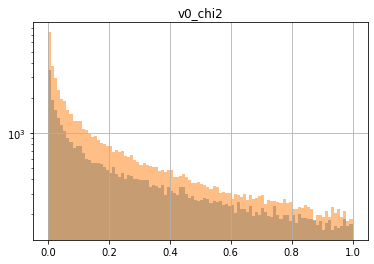

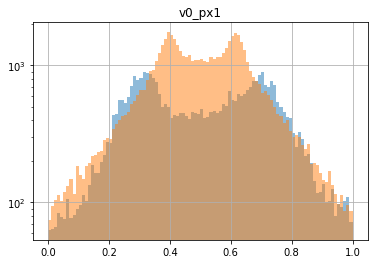

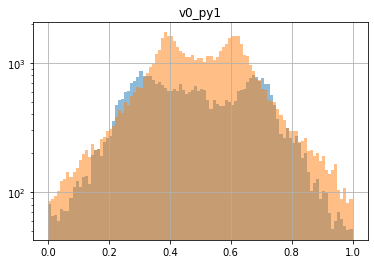

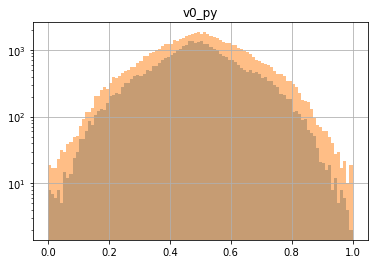

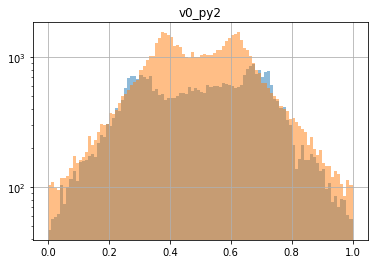

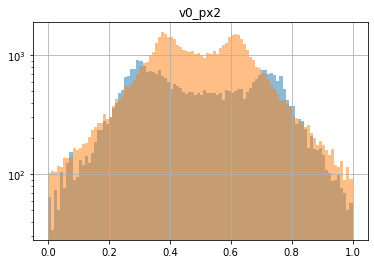

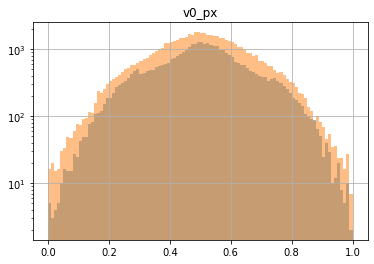

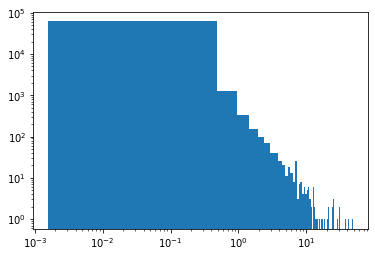

40498 63805


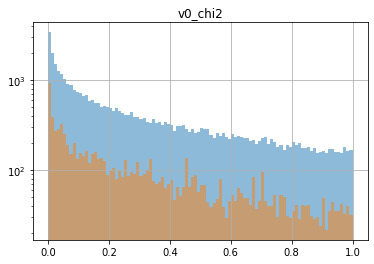

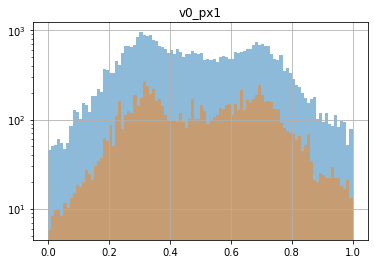

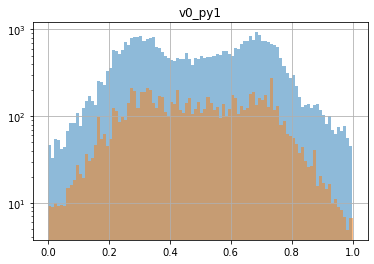

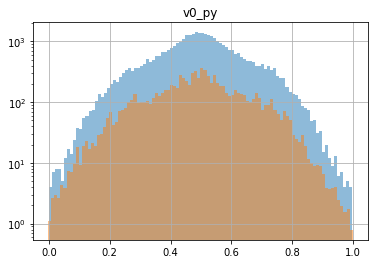

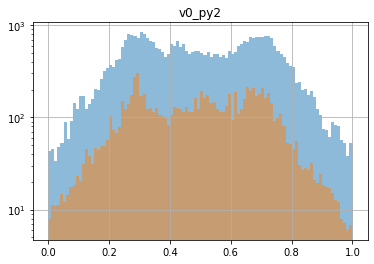

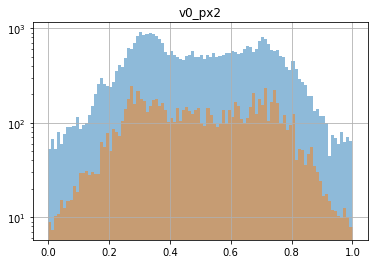

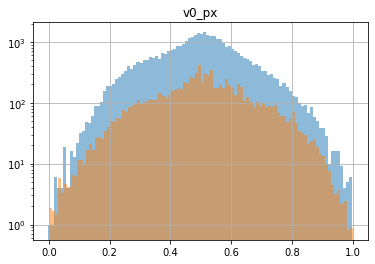

[0.0625292  0.18682182 0.18085936 0.11258664 0.15014353 0.16283047
 0.14422895]
[0.03082722 0.21568745 0.2239521  0.04056453 0.21699895 0.23403338
 0.03793634]


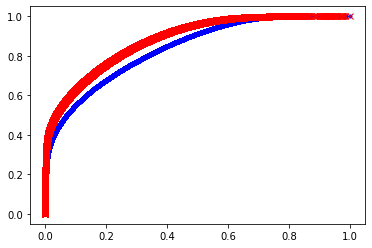

In [61]:
scaler_data_reweight1, scaler_mc_reweight1 = reweight_train(train_data,train_mc,ML1,cla_reweight1,test_data,test_mc,q_weights=0.999)

In [58]:
scaler_data_1, scaler_mc_1 = reweight_train(train_data,train_mc,ML1,cla1,reweighing=False,plot=False)

No valid minimum found!
Completed fit with Chi2: 79.4, p-val: 0.803 and the total amount of signal 6169 +/- 222, background: 116919
Completed fit with Chi2: 75.9, p-val: 0.873 and the total amount of signal 2295 +/- 0, background: 108485
Completed fit with Chi2: 74.2, p-val: 0.899 and the total amount of signal 1254 +/- 74, background: 97217
Completed fit with Chi2: 89.6, p-val: 0.520 and the total amount of signal 800 +/- 108, background: 85363
Completed fit with Chi2: 90.4, p-val: 0.497 and the total amount of signal 625 +/- 129, background: 73228
Completed fit with Chi2: 89.7, p-val: 0.520 and the total amount of signal 346 +/- 63, background: 61198
Completed fit with Chi2: 89.1, p-val: 0.537 and the total amount of signal 236 +/- 109, background: 49001
Completed fit with Chi2: 74.5, p-val: 0.895 and the total amount of signal 247 +/- 76, background: 36681
Completed fit with Chi2: 93.7, p-val: 0.403 and the total amount of signal 159 +/- 56, background: 24459
Completed fit with Chi2

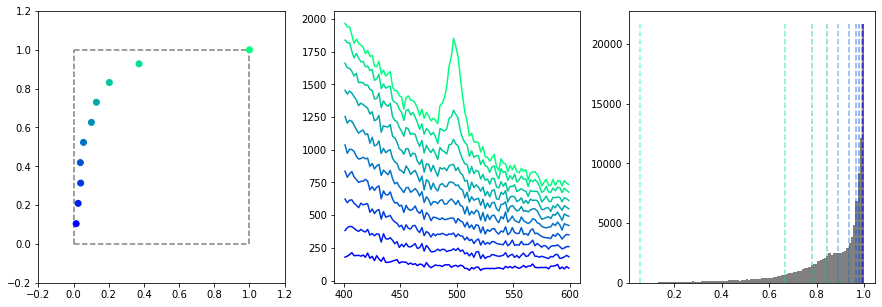

In [63]:
import importlib 
hm = importlib.reload(hm)

p1_reweight = cla_reweight1.predict_proba(pd.DataFrame(scaler_mc_reweight1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1r, ax1r = plt.subplots(figsize = (15,5),ncols=3)

AUC1r, cuts1r = hm.roc_curve_data(test_data.v0_ks_mass, p1_reweight,Npoints=10,ax_roc=ax1r[0],ax_fits=ax1r[1],ax_hist=ax1r[2])

No valid minimum found!
Completed fit with Chi2: 79.4, p-val: 0.803 and the total amount of signal 6169 +/- 222, background: 116919
Completed fit with Chi2: 81.7, p-val: 0.747 and the total amount of signal 2295 +/- 175, background: 108486
Completed fit with Chi2: 82.9, p-val: 0.716 and the total amount of signal 1222 +/- 79, background: 97250
Completed fit with Chi2: 75.6, p-val: 0.877 and the total amount of signal 816 +/- 104, background: 85347
Completed fit with Chi2: 90.0, p-val: 0.510 and the total amount of signal 536 +/- 102, background: 73318
Completed fit with Chi2: 86.2, p-val: 0.622 and the total amount of signal 439 +/- 1, background: 61106
Completed fit with Chi2: 93.0, p-val: 0.421 and the total amount of signal 299 +/- 30, background: 48937
Completed fit with Chi2: 84.8, p-val: 0.664 and the total amount of signal 338 +/- 97, background: 36590
Completed fit with Chi2: 67.3, p-val: 0.971 and the total amount of signal 252 +/- 4, background: 24367
Completed fit with Chi2:

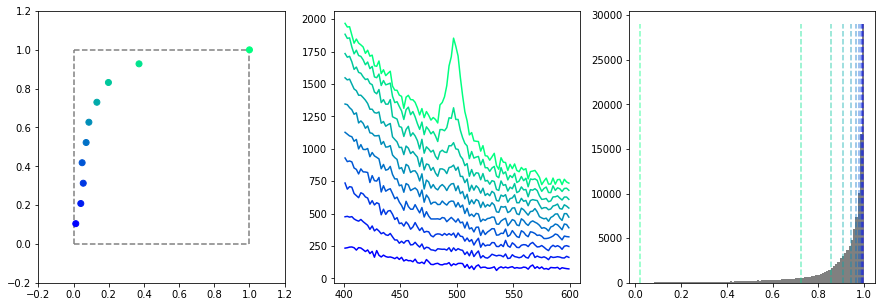

In [59]:
p1 = cla1.predict_proba(pd.DataFrame(scaler_mc_1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_ks_mass, p1,Npoints=10,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2])

No valid minimum found!
Completed fit with Chi2: 79.4, p-val: 0.803 and the total amount of signal 6169 +/- 222, background: 116919
Completed fit with Chi2: 77.9, p-val: 0.834 and the total amount of signal 4192 +/- 253, background: 116435
Completed fit with Chi2: 80.6, p-val: 0.773 and the total amount of signal 2328 +/- 275, background: 115838
Completed fit with Chi2: 84.2, p-val: 0.680 and the total amount of signal 1224 +/- 168, background: 114480
Completed fit with Chi2: 84.4, p-val: 0.674 and the total amount of signal 700 +/- 163, background: 112542
Completed fit with Chi2: 84.9, p-val: 0.661 and the total amount of signal 465 +/- 87, background: 110315
Completed fit with Chi2: 85.7, p-val: 0.637 and the total amount of signal 323 +/- 79, background: 107995
Completed fit with Chi2: 84.5, p-val: 0.672 and the total amount of signal 281 +/- 125, background: 105575
Completed fit with Chi2: 84.2, p-val: 0.679 and the total amount of signal 292 +/- 77, background: 103103
Completed fi

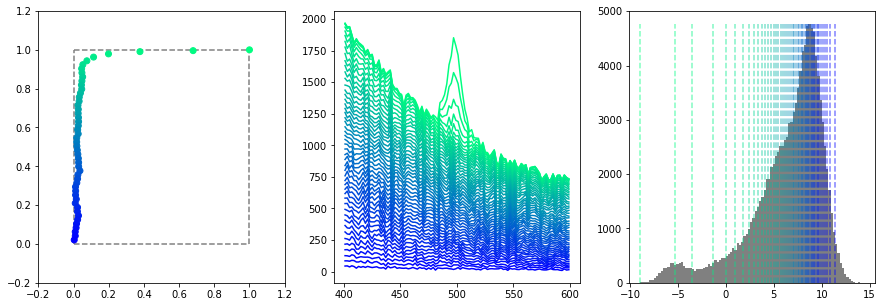

In [38]:
p1 = cla1.predict_proba(pd.DataFrame(scaler_data_1.transform(test_data[ML2]),columns=ML2))[:,0]

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_ks_mass, p1,Npoints=50,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2])

In [66]:
1+AUC1, 1+AUC1r, AUC1r-AUC1

(0.8667446366254846, 0.8704834956581978, 0.003738859032713232)

In [71]:
if type(train_data) != type(None):
    print('ok')

ok


In [67]:
type(None)

NoneType